In [137]:
# Using Torch Hub lib
import torch
import torchvision.utils as vutils

import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.manifold import TSNE

import os
from PIL import Image

import matplotlib.pyplot as plt

In [4]:
# Choose to use the device
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [140]:
# size of the latent space
latent_dim = 32

In [141]:
# 压缩后的图片尺寸，设置为64 * 64
SX = 64
SY = 64
N_CHANNELS = 1
LATENT_DIM = latent_dim

# 数据集的导入与处理
crop images by 128 x 128, downsize to 64 x 64

In [128]:
DATA_PATH = "./DATA/"
IMAGE_SUBPATH = "images"

df = pd.read_csv(os.path.join(DATA_PATH, "Dataset_descriptor.csv"), sep=",")

In [129]:
# shuffling dataframe
df = df.sample(frac=1).reset_index(drop=True)
df

,file name,sample id,position,temperature [C],Al-concentration [at.%],O-concentration [at.%],ionization degree [a.u.],average ion energy [eV],pressure [Pa],label
0,0001208_600-Pos4-50kx.jpg,1208,4,600,38.38000,10,0.500000,6.135100,0.5,facetted
1,0001208_200-Pos5-50kx.jpg,1208,5,200,32.90000,10,0.500000,6.437970,0.5,fine grained
2,0001208_200-Pos4-50kx.jpg,1208,4,200,38.38000,10,0.500000,6.135100,0.5,fine grained
3,4203_200_Pos05_50kx.jpg,4203,5,200,0.00000,3,0.357143,8.200000,0.5,facetted-oriented
4,0001208_600-Pos1-50kx.jpg,1208,1,600,54.85000,10,0.500000,7.143800,0.5,facetted
...,...,...,...,...,...,...,...,...,...,...
118,3824_2_50kx_20kV_WD10_ergebnis_ergebnis.jpg,3824,2,500,0.00000,0,0.111111,201.111111,0.5,smooth-facetted
119,3824_9_50kx_20kV_WD10_ergebnis_ergebnis.jpg,3824,9,500,0.00000,0,0.500000,205.000000,0.5,smooth-facetted
120,3824_7_50kx_20kV_WD10_ergebnis_ergebnis.jpg,3824,7,500,0.00000,0,0.250000,202.500000,0.5,smooth-facetted
121,1680-Pos8-50kx_ergebnis.jpg,1680,8,500,15.88576,0,1.000000,107.960700,0.5,smooth-facetted


In [130]:
df.columns

Index(['file name', 'sample id', 'position', 'temperature [C]',
       'Al-concentration [at.%]', 'O-concentration [at.%]',
       'ionization degree [a.u.]', 'average ion energy [eV]', 'pressure [Pa]',
       'label'],
      dtype='object')

In [131]:
Y_COLUMNS=['temperature [C]',
       'Al-concentration [at.%]', 'O-concentration [at.%]',
       'ionization degree [a.u.]', 'average ion energy [eV]', 'pressure [Pa]']

In [132]:
scaler = MinMaxScaler()

对information降维，观察其分布情况

d:\anaconda3\envs\pytorch\lib\site-packages\sklearn\manifold\_t_sne.py:996: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


temperature [C]


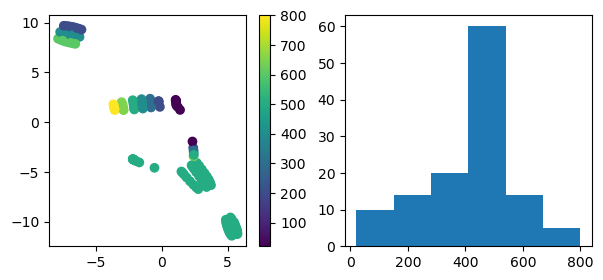

Al-concentration [at.%]


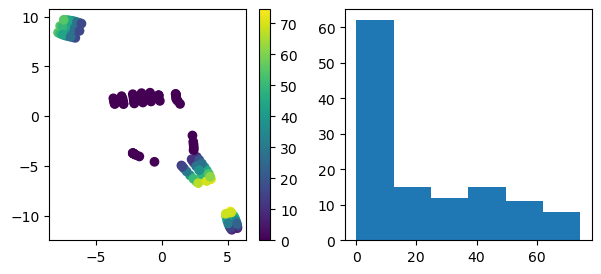

O-concentration [at.%]


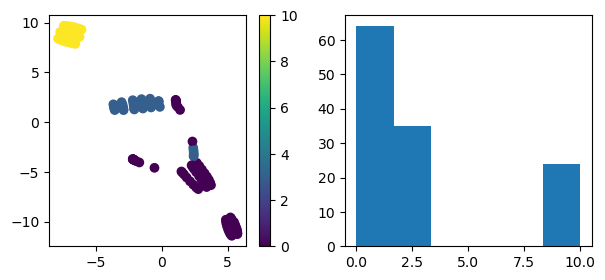

ionization degree [a.u.]


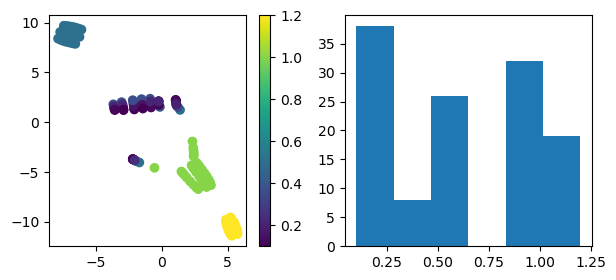

average ion energy [eV]


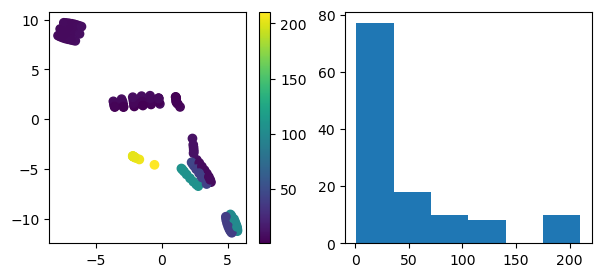

pressure [Pa]


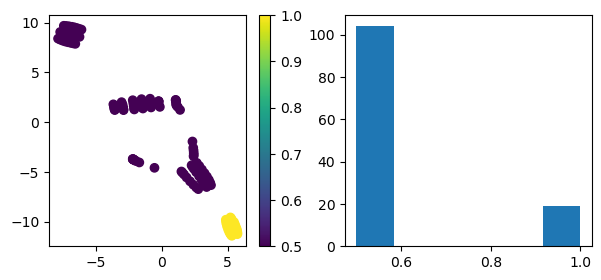

,temperature [C]_binning,Al-concentration [at.%]_binning,O-concentration [at.%]_binning,ionization degree [a.u.]_binning,average ion energy [eV]_binning,pressure [Pa]_binning,T
0,1,1,1,1,1,1,7
1,1,1,1,2,1,1,1
2,1,1,1,3,1,1,1
3,1,1,1,5,1,1,1
4,2,1,2,1,1,1,4
...,...,...,...,...,...,...,...
59,5,3,6,3,1,1,2
60,5,4,6,3,1,1,3
61,5,5,6,3,1,1,1
62,6,1,2,1,1,1,4


In [133]:
# 取我们需要用的值
y = df[Y_COLUMNS]
#做最大最小值归一化
y_scaled = scaler.fit_transform(y)
# 用tsne对标签进行降维, 默认是降到2维
tsne = TSNE(init='pca', learning_rate='auto')
y_tsne = tsne.fit_transform(y_scaled)

#number of bins per each extrinsic properties
BINS=6

for Y_column in Y_COLUMNS:
    print(Y_column)
    fig, axs= plt.subplots(1,2, figsize=(7,3))
    im=axs[0].scatter(y_tsne[:,0], y_tsne[:,1], c= df[Y_column])
    fig.colorbar(im, ax = axs[0])
    h=axs[1].hist(df[Y_column], bins=BINS)
    plt.show()

binning_labels_dict = {}
Y_COLUMNS_BINNING = []
for Y_column in Y_COLUMNS:
    # histogram means "直方图", bins是均匀分组后的边界
    cnt, bins = np.histogram(df[Y_column], bins=BINS)
    # 为什么要对这个减1？因为后面做searchsorted时，对这个边界的索引可能出问题
    bins[0] -= 1
    col_name = Y_column + "_binning"
    # 做这个操作是为了把所有的原始数据分成6组, 用1~6作为标签
    binning_labels_dict[col_name] = np.searchsorted(bins, df[Y_column].values)
    Y_COLUMNS_BINNING.append(col_name)

binning_df = pd.DataFrame(binning_labels_dict)
# 给其增加一列“T”，赋值全为1,用来计数，count之后T的值就是这种标签的个数
binning_df["T"] = 1
# 分别按照Y_COLUMNS_BINNING中的指标分组，统计每组的个数
# 这里按照这个列表去groupby,会自动列出所有可能的取值，然后再count，从而计算出每一类的数量，以及所有的类别，这个方法真的是特别巧妙
count_bins_df = binning_df.groupby(Y_COLUMNS_BINNING).count()
# 每个指标都有
# 这里补充一个reset_index的操作，原来的代码没有这个操作导致后面出问题了
count_bins_df = count_bins_df.reset_index()
count_bins_df

In [134]:
max_count=count_bins_df["T"].max()
# 与原始数据连接
df = pd.concat((df, binning_df), axis=1)
df.drop(labels="T", axis=1, inplace=True)
count_bins_df = count_bins_df.reset_index()

df=pd.merge(df,count_bins_df,on=Y_COLUMNS_BINNING)

df["weight"] = max_count/df["T"]

In [135]:
# 至此，csv数据处理完成
df

,file name,sample id,position,temperature [C],Al-concentration [at.%],O-concentration [at.%],ionization degree [a.u.],average ion energy [eV],pressure [Pa],label,temperature [C]_binning,Al-concentration [at.%]_binning,O-concentration [at.%]_binning,ionization degree [a.u.]_binning,average ion energy [eV]_binning,pressure [Pa]_binning,index,T,weight
0,0001208_600-Pos4-50kx.jpg,1208,4,600,38.38000,10,0.500000,6.13510,0.5,facetted,5,4,6,3,1,1,60,3,2.666667
1,0001208_600-Pos2-50kx.jpg,1208,2,600,49.36000,10,0.500000,6.69893,0.5,facetted,5,4,6,3,1,1,60,3,2.666667
2,0001208_600-Pos3-50kx.jpg,1208,3,600,43.86000,10,0.500000,6.31924,0.5,facetted,5,4,6,3,1,1,60,3,2.666667
3,0001208_200-Pos5-50kx.jpg,1208,5,200,32.90000,10,0.500000,6.43797,0.5,fine grained,2,3,6,3,1,1,8,2,4.000000
4,0001208_200-Pos6-50kx.jpg,1208,6,200,27.42000,10,0.500000,7.22784,0.5,fine grained,2,3,6,3,1,1,8,2,4.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118,1680-Pos6-50kx_ergebnis.jpg,1680,6,500,29.94711,0,1.000000,106.73417,0.5,smooth-facetted,4,3,1,5,4,1,37,1,8.000000
119,3824_10_50kx_20kV_WD10_ergebnis_ergebnis.jpg,3824,10,500,0.00000,0,1.000000,210.00000,0.5,smooth-facetted,4,1,1,5,6,1,24,1,8.000000
120,1680-Pos9-50kx_ergebnis.jpg,1680,9,500,11.78733,0,1.000000,108.49609,0.5,smooth-facetted,4,1,1,5,4,1,23,1,8.000000
121,3824_9_50kx_20kV_WD10_ergebnis_ergebnis.jpg,3824,9,500,0.00000,0,0.500000,205.00000,0.5,smooth-facetted,4,1,1,3,6,1,20,1,8.000000


In [144]:
# Image cropping & resizing 
BOX_SIZE = 128
BATCH_SIZE = 16
CROP_PER_IMAGE = 128

# ceil是向上取整
batch_count = int(np.ceil(len(df)/BATCH_SIZE))

YS = []
WEIGHTS = []
XS = []

for b in range(0, batch_count):
    print(b*BATCH_SIZE, "->", min(len(df), b*BATCH_SIZE+BATCH_SIZE)-1)
    batch_indices = np.arange(b*BATCH_SIZE,min(len(df),b*BATCH_SIZE+BATCH_SIZE))

    for ind in batch_indices:
        fname = df.loc[ind, "file name"]
        fname = os.path.join(DATA_PATH, IMAGE_SUBPATH, fname)
        im = Image.open(fname)
        for rep in range(CROP_PER_IMAGE):
            # 剪裁
            left = np.random.randint(0, im.width - BOX_SIZE)
            upper = np.random.randint(0, im.height - BOX_SIZE)

            box = left, upper, left+BOX_SIZE, upper+BOX_SIZE

            sub_image = im.crop(box)

            sub_image = sub_image.resize((SX, SY), resample=Image.Resampling.LANCZOS)

            sub_image_np = np.array(sub_image)
            sub_image_np = ((sub_image_np-127.5)/127.5).reshape(SX, SY, 1)
            # YS存储该图片对应的information
            YS.append(df.loc[ind, Y_COLUMNS].values)
            # WEIGHTS，存储这个图片的权重
            WEIGHTS.append(df.loc[ind, "weight"])
            # XS存储图片本身
            XS.append(sub_image_np)

        

0 -> 15
16 -> 31
32 -> 47
48 -> 63
64 -> 79
80 -> 95
96 -> 111
112 -> 122


In [145]:
YS = np.array(YS)
XS = np.array(XS)
WEIGHTS = np.array(WEIGHTS)

In [146]:
# 对标签信息做归一化
YS_scaled = scaler.fit_transform(YS)

array([0.74358974, 0.51497369, 1.        , 0.36363636, 0.02456986,
       0.        ])

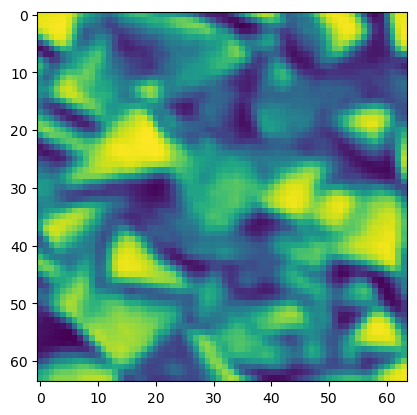

In [147]:
plt.imshow(XS[2,:,:,0])
YS_scaled[2]